# Building and running

In [1]:
import pandas as pd
import numpy as np
import cv2
import hashlib

from tensorflow import keras

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Load and prepare dataset
The dataset is composed by:
 * CSV with the labeling
 * Image folder with all the images normalized

In [2]:
dataset_folder = 'normalized_data_set_diagrams/'
labeled_csv = 'csv/diagram_images_dataset.csv'

In [3]:
map_to_name = {}


def load_dataset(dataset_folder_path, csv_path):
    """Loads a dataset of images
        - dataset_folder_path is the path of the folder that contains the images
        - csv_path is the path of the CSV file that contains the labels of the images
        Returns: X_data, y_labeled
        - X_data is a numpy.ndarray containing the pixel data of an image X
        - y_labeled is a numpy.ndarray containing an int, the label Y for the image X in that index
    """
    X_data = []

    data = pd.read_csv(csv_path, dtype={"Name": str, "Category": np.uint8})

    for image_name in data.Name:
        img = cv2.imread(dataset_folder_path + image_name, cv2.IMREAD_COLOR)
        hash = hashlib.sha1(img).hexdigest()[:15]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        map_to_name[hash] = image_name
        X_data.append(img)

    X_data = np.array(X_data)
    y_labeled = np.array(data.Category)

    print("Data loaded\n", data)
    return X_data, y_labeled

In [4]:
def preprocess_data(x, y, m):
    """Pre-processes the data for the model
        - x is a numpy.ndarray of shape (m, 224, 224, 3) containing
         a list of image pixels, where m is the number of images
        - y is a numpy.ndarray of shape (m,) containing
         the labels for x
        - m is the number of categories in the classifier
        Returns: X_p, Y_p
        - X_p is a numpy.ndarray containing the preprocessed X
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_p = keras.applications.densenet.preprocess_input(x)

    y_p = keras.utils.to_categorical(y, m)

    return X_p, y_p

In [5]:
X_full, y_full = load_dataset(dataset_folder, labeled_csv)
X_full_p, y_full_p = preprocess_data(X_full, y_full, 7)

Data loaded
                      Name  Category
0     7a668879d103ba8.jpg         1
1     4bab7d342c24e3f.jpg         1
2     d6c5e6d46cbbb26.jpg         1
3     e215c30192cc297.jpg         1
4     0fd2b9ef096d9cb.jpg         1
...                   ...       ...
5551  d2254621efd8d52.jpg         0
5552  de2268621d5e911.jpg         0
5553  90fe34f3f8107ee.jpg         0
5554  f065035fafcf430.jpg         0
5555  30efd0c8a1649e1.jpg         0

[5556 rows x 2 columns]


## Building DenseNet169

In [6]:
input_shape_densenet = (224, 224, 3)

In [7]:
def build_network(trainable: bool):
    """Pre-processes the data for the model
        Returns: densenet_model
        - densenet_model is a
    """
    densenet_model = keras.applications.DenseNet169(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape_densenet,
        pooling=None
    )
    densenet_model.trainable = True

    if trainable:
        for layer in densenet_model.layers:
            if 'conv5' in layer.name:
                layer.trainable = True
            else:
                layer.trainable = False

    return densenet_model

### Add new layers

In [8]:
def add_extra_layers(densenet_model, layer_size: int, dropout: bool, number_of_layers: int):
    """Add extra layers to a Keras model for transfer learning.
        - densenet_model is a pre-trained Keras model with input (224, 224, 3)
        - layer_size is an int, the size of the first Dense layer
        - dropout is a bool, indicating if a Dropout layer will be added
          between Dense layers
        Returns: model
        - model a Keras model with the layer added
    """
    initializer = keras.initializers.he_normal(seed=32)
    inputs = keras.Input(shape=input_shape_densenet)

    layer = densenet_model(inputs)
    layer = keras.layers.Flatten()(layer)

    layer = keras.layers.BatchNormalization()(layer)

    for n in range(1, number_of_layers+1):
        layer = keras.layers.Dense(units=layer_size/n,
                                   activation='relu',
                                   kernel_initializer=initializer
                                   )(layer)
        if dropout:
            layer = keras.layers.Dropout(0.5)(layer)

        layer = keras.layers.BatchNormalization()(layer)


    layer = keras.layers.Dense(units=7,
                               activation='softmax',
                               kernel_initializer=initializer
                               )(layer)

    model = keras.models.Model(inputs, outputs=layer)
    model.summary()

    return model

### Validating the results

In [9]:
def train_with_k_fold_cross_validation(n_folds: int, layer_size: int, trainable: bool, dropout: bool, number_of_layers: int):
    """Create and train a DenseNet model n_folds times with a different training/validation partition data.
        - n_folds the number of times the model will be trained
        - layer_size is an int, the size of the first Dense layer
        - trainable ia a bool, indicating if the last layer of the original model cold be re-trainable
        - dropout is a bool, indicating if a Dropout layer will be added
          between Dense layers
        Returns: histories
        - histories a list of size n_folds with the detailed training history of each attempt
    """
    histories = []
    for fold in range(n_folds):
        network = build_network(trainable)
        network = add_extra_layers(network, layer_size, dropout, number_of_layers)
        network.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])

        X_train, X_val, y_train, y_val = train_test_split(X_full_p, y_full_p, test_size=0.2, random_state=fold * 5)
        history = network.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
        del network
        histories.append(history)

    return histories

In [10]:
def train_with_simple_holdout_validation(X_train, X_val, y_train, y_val):
    network = build_network(True)
    network = add_extra_layers(network, 128, True, 1)
    network.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

    history = network.fit(X_train, y_train, epochs=9, validation_data=(X_val, y_val), verbose=1)

    network.save('diagrams.h5')
    return network

### Running the model

In [22]:
history_ini = []
folds = 4
max_layers = 3
TL = [True, False]
for op in TL:
    h = np.array(train_with_k_fold_cross_validation(folds, 128, op, True, 1))
    history_ini.append(h)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_1 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 81536)            326144    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               10436736  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                           

2022-08-08 03:46:32.982403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8852

2022-08-08 03:47:32.846850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 80s 475ms/step - loss: 0.3763 - accuracy: 0.8852 - val_loss: 0.1832 - val_accuracy: 0.9523
Epoch 2/10
139/139 [==============================] - 59s 421ms/step - loss: 0.1222 - accuracy: 0.9660 - val_loss: 0.0907 - val_accuracy: 0.9712
Epoch 3/10
139/139 [==============================] - 58s 414ms/step - loss: 0.0698 - accuracy: 0.9775 - val_loss: 0.1050 - val_accuracy: 0.9667
Epoch 4/10
139/139 [==============================] - 58s 413ms/step - loss: 0.0518 - accuracy: 0.9858 - val_loss: 0.0939 - val_accuracy: 0.9730
Epoch 5/10
139/139 [==============================] - 58s 417ms/step - loss: 0.0448 - accuracy: 0.9869 - val_loss: 0.0781 - val_accuracy: 0.9802
Epoch 6/10
139/139 [==============================] - 57s 412ms/step - loss: 0.0348 - accuracy: 0.9908 - val_loss: 0.1311 - val_accuracy: 0.9613
Epoch 7/10
139/139 [==============================] - 57s 409ms/step - loss: 0.0282 - accuracy: 0.9926 - val_loss: 0.0975 - val_accuracy: 0.9

2022-08-08 03:56:52.591367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.8182

2022-08-08 03:59:01.587882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 153s 951ms/step - loss: 0.5820 - accuracy: 0.8182 - val_loss: 1.3286 - val_accuracy: 0.7437
Epoch 2/10
139/139 [==============================] - 124s 888ms/step - loss: 0.2537 - accuracy: 0.9219 - val_loss: 0.8900 - val_accuracy: 0.7419
Epoch 3/10
139/139 [==============================] - 124s 884ms/step - loss: 0.2086 - accuracy: 0.9392 - val_loss: 1.1409 - val_accuracy: 0.6969
Epoch 4/10
139/139 [==============================] - 124s 887ms/step - loss: 0.1163 - accuracy: 0.9635 - val_loss: 1.0123 - val_accuracy: 0.7329
Epoch 5/10
139/139 [==============================] - 125s 898ms/step - loss: 0.0934 - accuracy: 0.9737 - val_loss: 0.1697 - val_accuracy: 0.9460
Epoch 6/10
139/139 [==============================] - 125s 893ms/step - loss: 0.0916 - accuracy: 0.9696 - val_loss: 0.2291 - val_accuracy: 0.9218
Epoch 7/10
139/139 [==============================] - 123s 881ms/step - loss: 0.1071 - accuracy: 0.9671 - val_loss: 0.5190 - val_accura

### Showing the results

In [19]:
def show_and_predict_img(name: str, model):
    img = cv2.imread('test/' + name, cv2.IMREAD_ANYCOLOR)
    im = np.array([img])
    im = keras.applications.densenet.preprocess_input(im)

    cv2.imshow('img', img)
    cv2.waitKey(0)
    return model.predict(im)

In [20]:
def get_history_mean(k_history, prop: str):
    val_acc = [h.history[prop] for h in k_history]
    mean = np.mean(val_acc, axis=0)
    return mean

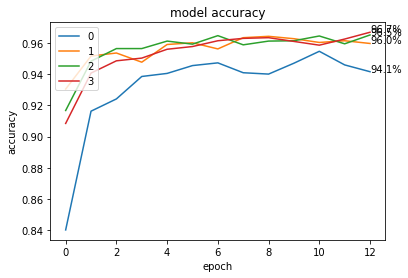

In [19]:
means = map(get_history_mean, history, ['val_accuracy'] * len(history))

plot_model_accuracy(means, ['0', '1', '2', '3'])

In [11]:
def plot_model_accuracy(accs, losses, legends):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    for acc in accs:
        plt.plot(acc)
        l = len(acc) - 1
        plt.text(l, acc[l], "{:.1f}%".format(acc[l] * 100))
    plt.legend(legends, loc='lower right')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.subplot(1,2,2)
    for loss in losses:
        plt.plot(loss)
        l = len(loss) - 1
        plt.text(l, loss[l], "{:.1f}%".format(loss[l] * 100))
    plt.legend(legends, loc='upper right')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('number_of_layers.png')
    plt.show()

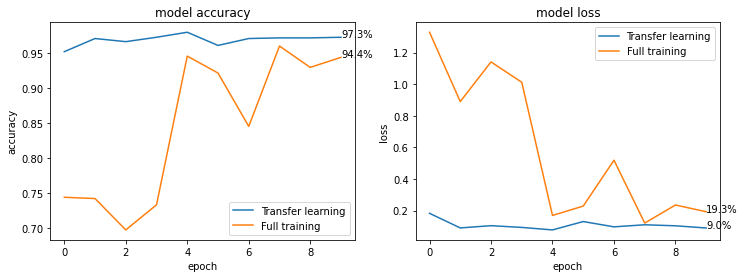

In [23]:
val_acc = map(get_history_mean, history_ini, ['val_accuracy'] * len(history_ini))
acc = map(get_history_mean, history_ini, ['accuracy'] * len(history_ini))
val_loss = map(get_history_mean, history_ini, ['val_loss'] * len(history_ini))
loss = map(get_history_mean, history_ini, ['val_loss'] * len(history_ini))

plot_model_accuracy(val_acc, loss, ["Transfer learning", "Full training"])

### Validating and mesure model

In [17]:
def validate_failed(model, X, y, X_original, show_image: bool):
    prob = model.predict(X, verbose=1)
    predictions = prob.argmax(axis=-1)
    expected_y = y.argmax(axis=-1)
    fails = 0
    for i in range(len(predictions)):
        if predictions[i] != expected_y[i]:
            fails += 1
            if show_image:
                hash = hashlib.sha1(X_original[i]).hexdigest()[:15]
                name = map_to_name[hash]
                print(
                    f'\r{name} Expected {expected_y[i]} ({prob[i][expected_y[i]]}) but got {predictions[i]} ({prob[i][predictions[i]]})',
                    flush=True, end=' ' * 50)
                cv2.imshow('Failed', X_val[i])
                cv2.imshow('Original', X_original[i])
                cv2.waitKey(0)
    print(f'Failed: {fails}')

    return classification_report(expected_y, predictions, digits=4)

In [13]:
seed = 40

X_train, X_val, y_train, y_val = train_test_split(X_full_p, y_full_p, test_size=0.2, random_state=seed)
_, X_original, _, _ = train_test_split(X_full, y_full, test_size=0.2, random_state=seed)

model = train_with_simple_holdout_validation(X_train, X_val, y_train, y_val)

2022-08-07 21:45:38.793762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-07 21:45:38.794196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               10436736  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                           

2022-08-07 21:45:43.919718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-07 21:45:48.608564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.8927

2022-08-07 21:47:07.075152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 97s 643ms/step - loss: 0.3445 - accuracy: 0.8927 - val_loss: 0.2019 - val_accuracy: 0.9433
Epoch 2/9
139/139 [==============================] - 55s 398ms/step - loss: 0.0997 - accuracy: 0.9734 - val_loss: 0.1229 - val_accuracy: 0.9568
Epoch 3/9
139/139 [==============================] - 54s 386ms/step - loss: 0.0715 - accuracy: 0.9806 - val_loss: 0.1058 - val_accuracy: 0.9712
Epoch 4/9
139/139 [==============================] - 55s 398ms/step - loss: 0.0404 - accuracy: 0.9876 - val_loss: 0.1264 - val_accuracy: 0.9676
Epoch 5/9
139/139 [==============================] - 56s 402ms/step - loss: 0.0433 - accuracy: 0.9865 - val_loss: 0.0935 - val_accuracy: 0.9775
Epoch 6/9
139/139 [==============================] - 56s 402ms/step - loss: 0.0475 - accuracy: 0.9840 - val_loss: 0.1744 - val_accuracy: 0.9568
Epoch 7/9
139/139 [==============================] - 55s 393ms/step - loss: 0.0319 - accuracy: 0.9905 - val_loss: 0.1116 - val_accuracy: 0.9730
Ep

In [18]:
failed = validate_failed(model, X_val, y_val, X_original, False)
print(failed)

35/35 [==============================] - 8s 190ms/step
Failed: 24
              precision    recall  f1-score   support

           0     0.9950    0.9659    0.9802       205
           1     0.9921    0.9766    0.9843       128
           2     0.9939    0.9878    0.9908       164
           3     0.9667    0.9902    0.9783       205
           4     0.9677    0.9231    0.9449        65
           5     0.9632    0.9752    0.9691       161
           6     0.9683    0.9946    0.9812       184

    accuracy                         0.9784      1112
   macro avg     0.9781    0.9733    0.9755      1112
weighted avg     0.9786    0.9784    0.9784      1112



### Testing new cases

In [ ]:
loaded_model = keras.models.load_model('diagrams.h5')

In [14]:
show_and_predict_img('conceptual.jpg', loaded_model)

array([[0.00571571, 0.16076495, 0.03779309, 0.16143267, 0.58737206,
        0.01790639, 0.01244646, 0.01656868]], dtype=float32)